In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by agency

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [3]:
table_df = df.copy()
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df

,agency,observed_boardings,model_boardings,diff,perc_diff
2,King County Metro,"253,313.62","326,079.65","72,766.03",28.73%
5,Sound Transit,"113,374.00","146,858.46","33,484.46",29.53%
0,Community Transit,"25,962.00","23,956.43","-2,005.57",-7.73%
4,Pierce Transit,"21,185.00","19,720.86","-1,464.14",-6.91%
6,Washington Ferries,"9,278.21","9,549.19",270.98,2.92%
3,Kitsap Transit,"7,789.00","36,455.89","28,666.89",368.04%
1,Everett Transit,"4,201.00","2,700.08","-1,500.92",-35.73%


In [4]:
# fig = px.bar(plot_df.sort_values('source'), x="agency", y="count",
#              color="source", barmode="group",
#              title="transit boardings by agency")
# fig.update_layout(height=400, width=700, font=dict(size=11),
#                   yaxis_tickformat = '.2f')
# fig.show()

### boarding by key route

In [5]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,973 W Sea Water Taxi,759.00,"1,049.15",290.15,38.23%
1,975 Vashn Water Taxi,338.00,932.62,594.62,175.92%
2,WSF Edmonds-Kingston,"1,500.13",232.64,"-1,267.49",-84.49%
3,WSF Seattle-Bain Isl,"5,513.69","6,623.34","1,109.65",20.13%
4,WSF Seattle-Brem,"1,188.97",375.90,-813.07,-68.38%
5,WSF Fauntleroy-Swrth,142.56,573.83,431.27,302.51%
6,WSF Fauntleroy-Vashn,560.04,"1,486.01",925.96,165.34%
7,WSF Vashon-Southwrth,107.76,104.65,-3.11,-2.88%
8,WSF Pt Def-Tahlequah,265.05,152.83,-112.23,-42.34%


r^2 : 0.9313671792256871


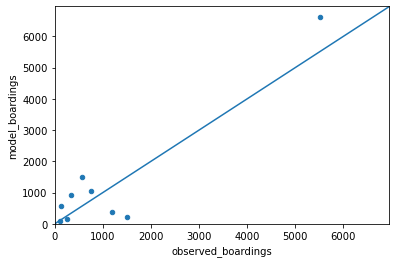

In [6]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

##### bikes on ferry

In [7]:
df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
df['route_code'] = df['route_code'].astype('int')
df[['route_code','description', '@bvol']]

,route_code,description,@bvol
4,4203,Seattle-Kingston FF,822.60
2,4200,Seattle-Bremerton FF,486.80
3,4201,Brem-Pt Orchard FF,434.70
0,1973,973 W Sea Water Taxi,338.10
1,1975,975 Vashn Water Taxi,182.10
7,5002,WSF Seattle-Bain Isl,109.40
10,5005,WSF Fauntleroy-Vashn,73.40
11,5007,WSF Pt Def-Tahlequah,56.00
9,5004,WSF Fauntleroy-Swrth,36.10
6,5001,WSF Edmonds-Kingston,26.10


In [8]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Link Red Line,"79,522.00","71,122.44","-8,399.56",-10.56%
1,Sounder South,"6,038.00","12,376.07","6,338.07",104.97%
2,Sounder North,316.00,10.74,-305.26,-96.60%


r^2 : 0.9951389544400652


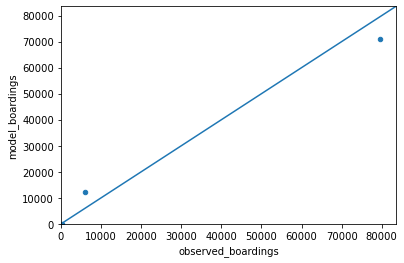

In [9]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [10]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
6,E Line RapidRide,"11,426.00","17,902.60","6,476.60",56.68%
4,C Line RapidRide,"7,250.00","14,353.54","7,103.54",97.98%
1,KC Metro 40,"7,208.00","11,853.15","4,645.15",64.44%
0,KC Metro 7,"9,954.00","10,111.59",157.59,1.58%
10,Sound Transit 550,"3,351.00","9,333.40","5,982.40",178.53%
5,D Line RapidRide,"9,044.00","9,022.25",-21.75,-0.24%
2,A Line RapidRide,"8,412.00","7,489.23",-922.77,-10.97%
7,F Line RapidRide,"4,748.00","5,457.30",709.30,14.94%
3,B Line RapidRide,"4,177.00","4,066.39",-110.61,-2.65%
8,SLU Streetcar,"1,050.16",964.66,-85.51,-8.14%


r^2 : 0.776801782732878


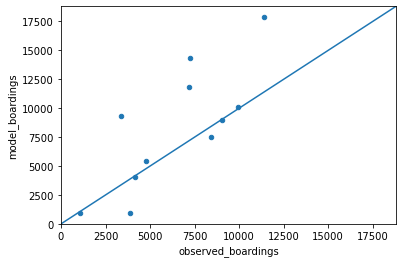

In [11]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### boarding on lines by agency

r^2 Community Transit: 0.9301642703032877


r^2 Everett Transit: 0.9612795883957796
r^2 King County Metro: 0.8972692314984186
r^2 Kitsap Transit: 0.8503185154164136
r^2 Pierce Transit: 0.7709237097649431


r^2 Sound Transit: 0.9862602458402967
r^2 Washington Ferries: 0.9384383268392203


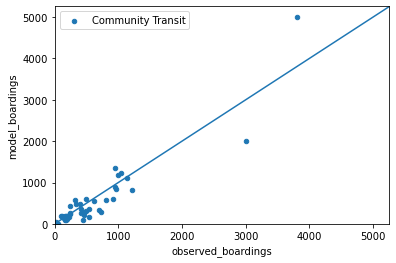

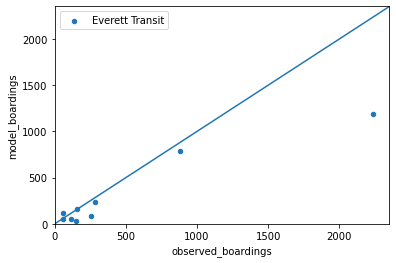

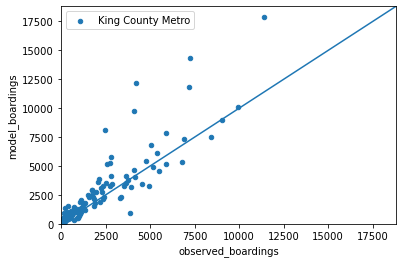

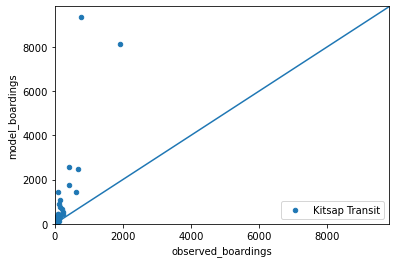

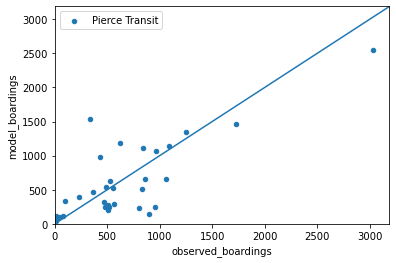

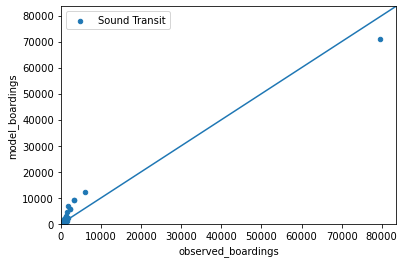

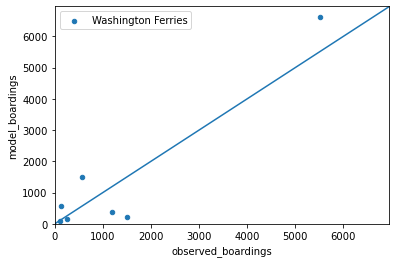

In [12]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [13]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Husky Stadium,"6,134.00","4,447.86","-1,686.14",-27.49%
Westlake,"8,845.00","8,780.78",-64.22,-0.73%
University St,"4,324.00","5,832.47","1,508.47",34.89%
Pioneer Square,"2,400.00","5,133.87","2,733.87",113.91%
Int'l District,"4,399.00","1,606.00","-2,793.00",-63.49%
Capitol Hill,"7,667.00","5,681.56","-1,985.44",-25.90%
Stadium,"1,731.00",531.06,"-1,199.94",-69.32%
SODO,"1,669.00","2,571.04",902.04,54.05%
Beacon Hill,"2,147.00",875.82,"-1,271.18",-59.21%


In [14]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/University St'
df_combined.loc[['University St'],'station_group'] = 'Westlake/University St'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined.loc[['Husky Stadium','Capitol Hill','Westlake/University St',"Pioneer Square/Int'l District",
                 'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                 "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Husky Stadium,"6,134.00","4,447.86","-1,686.14",-27.49%
Capitol Hill,"7,667.00","5,681.56","-1,985.44",-25.90%
Westlake/University St,"13,169.00","14,613.25","1,444.25",10.97%
Pioneer Square/Int'l District,"6,799.00","6,739.87",-59.13,-0.87%
Stadium/SODO,"3,400.00","3,102.10",-297.90,-8.76%
Beacon Hill/Mount Baker,"4,008.00","1,819.80","-2,188.20",-54.60%
Columbia City,"1,630.00","1,030.78",-599.22,-36.76%
Othello/Rainier Beach,"3,525.00","2,232.41","-1,292.59",-36.67%
Tukwila Int'l Blvd,"2,298.00","1,836.70",-461.30,-20.07%


### light rail stop transfers

In [15]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Husky Stadium,0.93,-99.00,99.93,-100.94%
Westlake,0.15,0.36,-0.22,-59.69%
University St,0.24,0.20,0.04,20.31%
Pioneer Square,0.45,0.16,0.29,180.89%
Int'l District,0.65,0.45,0.20,44.40%
Capitol Hill,0.07,-99.00,99.07,-100.07%
Stadium,0.23,0.12,0.11,92.38%
SODO,0.48,0.31,0.17,54.84%
Beacon Hill,0.32,0.35,-0.03,-8.71%
